### 0. Acknowledgments and Introduction

Thanks to @mrdbourke and his PyTorch learning course https://www.youtube.com/watch?v=Z_ikDlimN6A&t=285s

I made my our modified version of CNN FashionMNIST classification, and I was able to get the test accuracy to 93.23%
* 3 blocks of CNN:
  * Fisrt block pooling on vertical feature
  * Second block pooling on horizontal feature
  * Third block pooling on square feature
* Each of the CNN block contains:
  * Normliztion layer
  * Conv2d layer
  * GELU layer
  * Normliztion layer
  * Conv2d layer
  * Dropout layer
  * MaxPool layer
* Specifications of this Model:
  * Converge fast, more than 90% test accuracy after 3 Epochs
  * Can achieve test accuracy more than 92.8% accuracy after 15 Epochs

### 1. Import libraries

In [243]:
# Import Pytorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import DataLoader
from torch.utils.data import DataLoader

# Import timer
from timeit import default_timer as timer

# Import tqdm pythong progress bar
from tqdm.auto import tqdm

# Import matplotlib for visionlizatiopn
import matplotlib.pyplot as plt

# Import mlxtend
import mlxtend
from torchmetrics import Accuracy
from torchmetrics import ConfusionMatrix
from mlxtend.plotting.plot_confusion_matrix import plot_confusion_matrix

print(f"Torch version: {torch.__version__}")
print(f"TorchVision version: {torchvision.__version__}")
print(f"mlxtend version: {mlxtend.__version__}")

Torch version: 2.2.2+cu121
TorchVision version: 0.17.2+cu121
mlxtend version: 0.23.1


### 2. Load/Download train/test dataset

In [244]:
# Setup training data
train_data = datasets.FashionMNIST(root="data",
                                   train=True, 
                                   download=True, 
                                   transform=torchvision.transforms.ToTensor(), # Cover it to tensor
                                   target_transform=None) 
# Setup testing data
test_data = datasets.FashionMNIST(root="data",
                                  train=False,
                                  download=True,
                                  transform=ToTensor(),
                                  target_transform=None)

### 3. Glance of the dataset

In [245]:
print(f"Train Length: {len(train_data)}\nTest  Length: {len(test_data)}")

Train Length: 60000
Test  Length: 10000


In [246]:
class_names = train_data.classes
print(f"All classes: {class_names}")

All classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [247]:
# Helper function for plot sample data
def plotSample(data):
    fig=plt.figure(figsize=(10,5))
    rows, cols = 4, 8
    for i in range(1, rows*cols+1):
        random_idx = torch.randint(0, len(data), size=[1]).item()
        img, label = data[random_idx]
        fig.add_subplot(rows, cols, i)
        plt.imshow(img.permute(1,2,0), cmap="gray")
        plt.title(class_names[label], fontsize = 8)
        plt.axis(False)

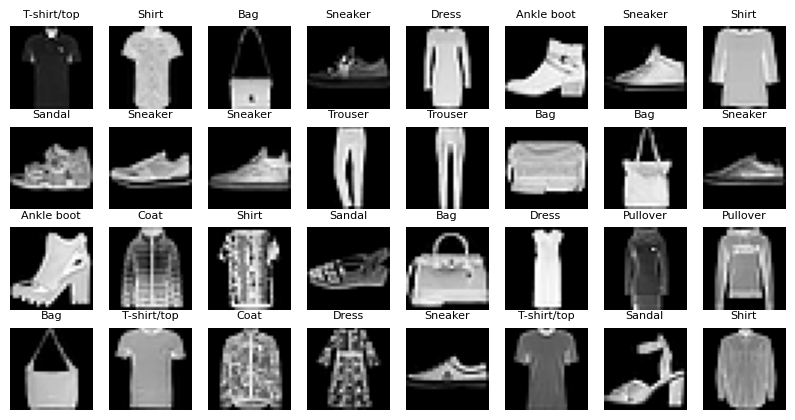

In [248]:
# Sample of the train_data
plotSample(train_data)

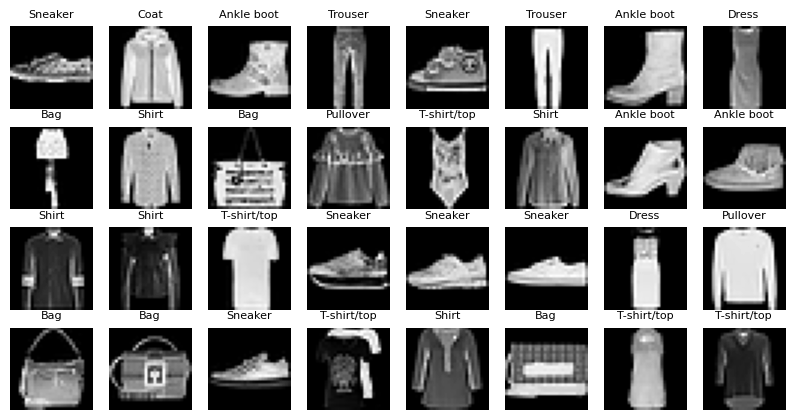

In [249]:
# Sample of the test_data
plotSample(test_data)

### 4. Prepare DataLoader

In [250]:
# Setup the batch size, recommended batch size is 32
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True) # some of the data setup may store the same classification together, remember to shuffle.
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

In [251]:
print(f"Dataloaders:\n\nTrain:{train_dataloader.dataset}\n\nTest:{test_dataloader.dataset}\n")
print(f"Len of train_dataloaders: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Len of test_dataloaders: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders:

Train:Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

Test:Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

Len of train_dataloaders: 1875 batches of 32
Len of test_dataloaders: 313 batches of 32


In [252]:
train_set_batch, train_labels_batch = next(iter(train_dataloader))
print(f"Train data batch shape: {train_set_batch.shape}, Train label batch shape: {train_labels_batch.shape}")

Train data batch shape: torch.Size([32, 1, 28, 28]), Train label batch shape: torch.Size([32])


### 5. Device agnostic code

In [253]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on: {device}")
if device == "cuda":
    print(f"    Number of GPU : {torch.cuda.device_count()}")
    print(f"    Current device: {torch.cuda.current_device()}")
    print(f"    Device Name   : {torch.cuda.get_device_name(0)}")
    print('    Memory Usage:')
    print('      Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('      Cached   :', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Running on: cuda
    Number of GPU : 1
    Current device: 0
    Device Name   : NVIDIA GeForce GTX 960M
    Memory Usage:
      Allocated: 0.1 GB
      Cached   : 0.2 GB


### 6. CNN model setup

In [254]:
# Create a convolutional neural network
class CNNFashionMNIST(nn.Module):
    """
    3 blocks of CNN:
        Fisrt block pooling on vertical feature
        Second block pooling on horizontal feature
        Third block pooling on square feature
    Each of the CNN block contains:
        Normliztion layer
        Conv2d layer
        GELU layer
        Normliztion layer
        Conv2d layer
        Dropout layer
        MaxPool layer
    Specifications of this Model:
        Converge fast, more than 90% test accuracy after 3 Epochs
        Can achieve test accuracy more than 92.8% accuracy after 15 Epochs
    """
    def __init__(self, input_shape:int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.BatchNorm2d(1),
            nn.Conv2d(in_channels=input_shape,
                     out_channels=10,
                     kernel_size=3,
                     stride=1,
                     padding=1),
            nn.GELU(),
            nn.BatchNorm2d(10),
            nn.Conv2d(in_channels=10,
                      out_channels=32,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.GELU(),
            nn.Dropout(p=0.1),
            nn.MaxPool2d(kernel_size=(2,1)) # Pooling vertical feature
        )
        self.conv_block_2 = nn.Sequential(
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32,
                      out_channels=32,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.GELU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32,
                      out_channels=32,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.GELU(),
            nn.Dropout(p=0.1),
            nn.MaxPool2d(kernel_size=(1,2)) # Pooling horizontal feature
        )
        self.conv_block_3 = nn.Sequential(
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32,
                      out_channels=32,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.GELU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32,
                      out_channels=10,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.GELU(),
            nn.Dropout(p=0.1),
            nn.MaxPool2d(kernel_size=2)  # Pooling square
        )
        self.classifier = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.BatchNorm1d(num_features=7*7*10),
            nn.Linear(in_features=7*7*10,
                      out_features=output_shape)
        )
    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.classifier(x)
        return x

In [255]:
# Use Sheldon Prime as seed
SHELDON_PRIME_SEED = 73
torch.manual_seed(SHELDON_PRIME_SEED)
torch.cuda.manual_seed(SHELDON_PRIME_SEED)

# Create Model
model_cnn = CNNFashionMNIST(input_shape=1, output_shape=len(class_names)).to(device)

### 7. Training step and Testing step function

In [256]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device,):
    """ Performs a training with mode trying to to learn on data_loader."""
    train_loss, train_acc = 0, 0
    model.train()

    # Add a loop to loop trhoug the trainging batches
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        # 1. Forwad pass
        y_pred = model(X)
        # 2. Calcutlate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss #accumlate train loss
        train_acc += torch.eq(y, y_pred.argmax(dim=1)).sum().item()
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        # 4. Loss backward
        loss.backward()
        # 5. Optimzer step
        optimizer.step()

    # Devide total train loss and acc by length of traing dataloader
    train_loss /= len(data_loader)
    train_acc /= len(data_loader.dataset)
    print(f"Train loss: {train_loss:.5f}, Train acc: {train_acc*100:.2f}% | ", end="")

In [257]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = device):
    """Performs a testing loop step on model going over data_loader."""
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X_test, y_test in data_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            # 1. Foward pass
            test_pred = model(X_test)
            # 2. Calculate loss (acculatively)
            test_loss += loss_fn(test_pred, y_test)
            # 3. Calculate accuracy
            test_acc += torch.eq(y_test, test_pred.argmax(dim=1)).sum().item()
        # Calculate the test loss average per batch
        test_loss /= len(data_loader)
        # Calculate the test acc average per batch
        test_acc /= len(data_loader.dataset)
        print(f"Test loss: {test_loss:.5f}, Test acc: {test_acc*100:.4f}%")

### 8. Start Training

In [258]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_cnn.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

# Train and test model 
epochs = 35

train_time_start = timer()
for epoch in tqdm(range(epochs)):

    print(f"Epoch {epoch:3.0f}: learning rate: {scheduler.get_last_lr()}")
    print(f"           ", end="")
    train_step(data_loader=train_dataloader, 
        model=model_cnn, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model_cnn,
        loss_fn=loss_fn,
        device=device
    )

    if epoch < epochs * 3 / 4: # After learning rate get too small stop step scheduler
        scheduler.step()

train_time_end = timer()
print(f"Train time on {device}: {train_time_end - train_time_start:.4f} seconds")

  0%|          | 0/35 [00:00<?, ?it/s]

Epoch   0: learning rate: [0.1]
           Train loss: 0.39824, Train acc: 86.10% | Test loss: 0.28206, Test acc: 89.6500%
Epoch   1: learning rate: [0.08000000000000002]
           Train loss: 0.27804, Train acc: 90.26% | Test loss: 0.30342, Test acc: 88.5600%
Epoch   2: learning rate: [0.06400000000000002]
           Train loss: 0.24195, Train acc: 91.33% | Test loss: 0.25289, Test acc: 90.5500%
Epoch   3: learning rate: [0.051200000000000016]
           Train loss: 0.21549, Train acc: 92.22% | Test loss: 0.21728, Test acc: 92.2400%
Epoch   4: learning rate: [0.04096000000000002]
           Train loss: 0.19756, Train acc: 92.91% | Test loss: 0.21756, Test acc: 92.3000%
Epoch   5: learning rate: [0.03276800000000001]
           Train loss: 0.18357, Train acc: 93.37% | Test loss: 0.21921, Test acc: 92.1100%
Epoch   6: learning rate: [0.026214400000000013]
           Train loss: 0.17084, Train acc: 93.78% | Test loss: 0.20745, Test acc: 92.5100%
Epoch   7: learning rate: [0.020971520000

### 9. Showing the model result

In [259]:
model_cnn.eval()
y_preds = []
with torch.inference_mode():
    for X_test, y_test in test_dataloader:
        X_test, y_test = X_test.to(device), y_test.to(device)
        y_logit = model_cnn(X_test)
        y_pred = y_logit.argmax(dim=1)
        y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds)

In [260]:
confmat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
confmat_tensor = confmat(preds=y_pred_tensor, target=test_data.targets)
print(confmat_tensor)

tensor([[873,   0,  14,  10,   2,   1,  98,   0,   2,   0],
        [  0, 987,   0,  11,   0,   0,   0,   0,   2,   0],
        [ 14,   1, 930,   9,  20,   0,  26,   0,   0,   0],
        [  5,   3,  12, 949,  12,   0,  19,   0,   0,   0],
        [  1,   1,  44,  25, 865,   0,  64,   0,   0,   0],
        [  0,   0,   0,   0,   0, 990,   0,   9,   0,   1],
        [ 84,   2,  40,  28,  42,   0, 802,   0,   2,   0],
        [  0,   0,   0,   0,   0,   5,   0, 985,   0,  10],
        [  1,   3,   1,   5,   0,   1,   1,   1, 987,   0],
        [  0,   0,   0,   0,   0,   6,   0,  39,   0, 955]])


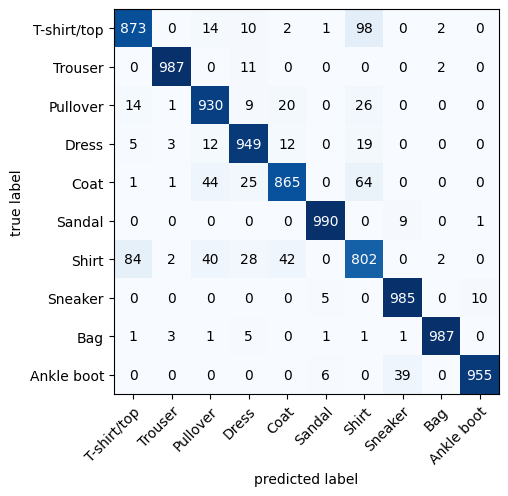

In [261]:
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(8,5)
)

In [262]:
accuracy = Accuracy(task="multiclass", num_classes=len(class_names))
print(f"Total test accuracy: {accuracy(y_pred_tensor, test_data.targets).item()*100:.4f}%")

Total test accuracy: 93.2300%


In [264]:
# Saving our PyTorch model
from pathlib import Path
# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "PyTorch_CNN_FashionMNIST_model.pt"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state_dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_cnn.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models\PyTorch_CNN_FashionMNIST_model.pt
